# **Important Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# **Read Data**

In [2]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# **EDA & Visualize**

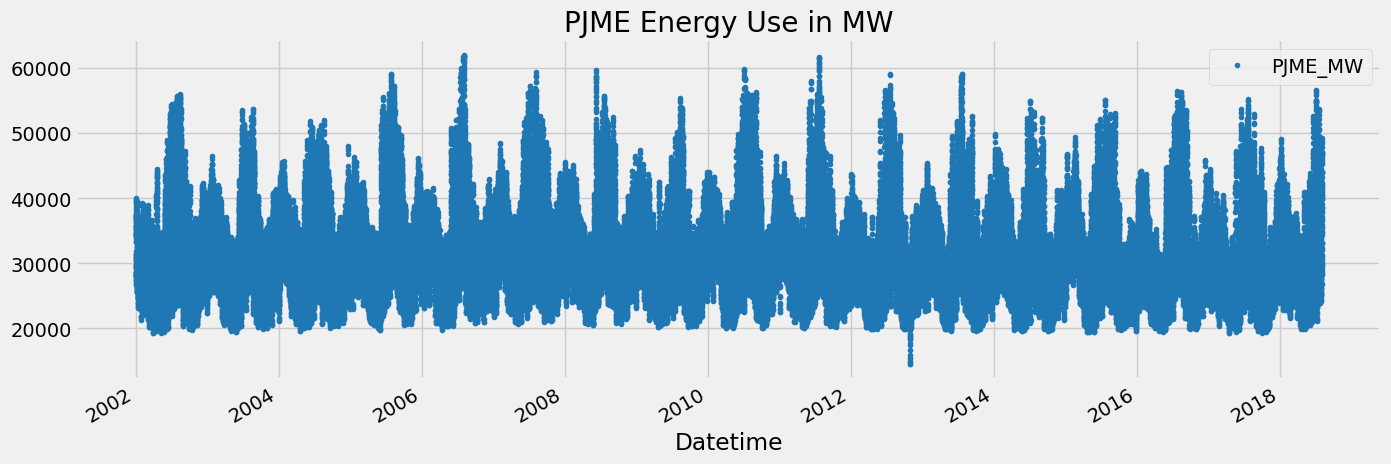

In [3]:
df.plot(
    style='.',
    figsize=(15,5),
    color = color_pal[0],
    title='PJME Energy Use in MW'
)
plt.show()

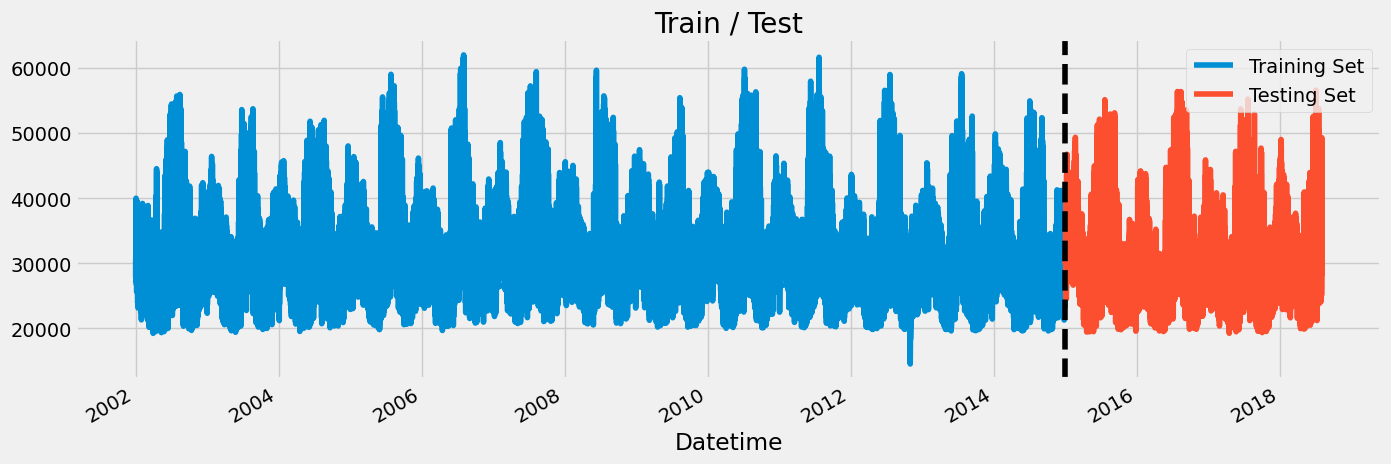

In [4]:
# Train and Test split
train = df.iloc[df.index < '01-01-2015']
test = df.iloc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Train / Test')
test.plot(ax=ax, label='Testing Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set','Testing Set'])
plt.show()

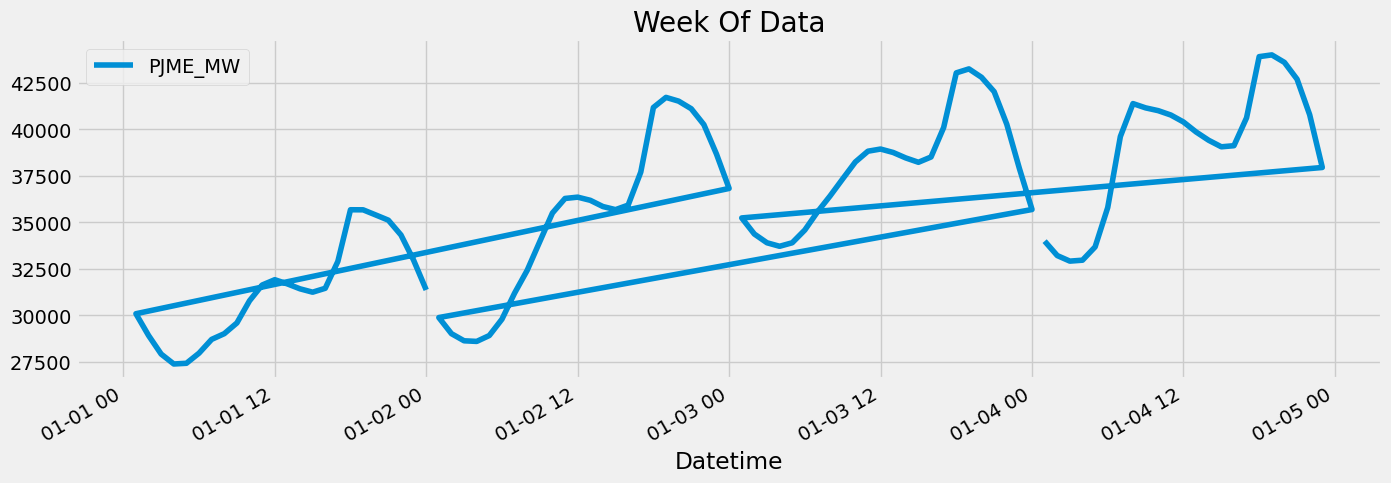

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-05-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


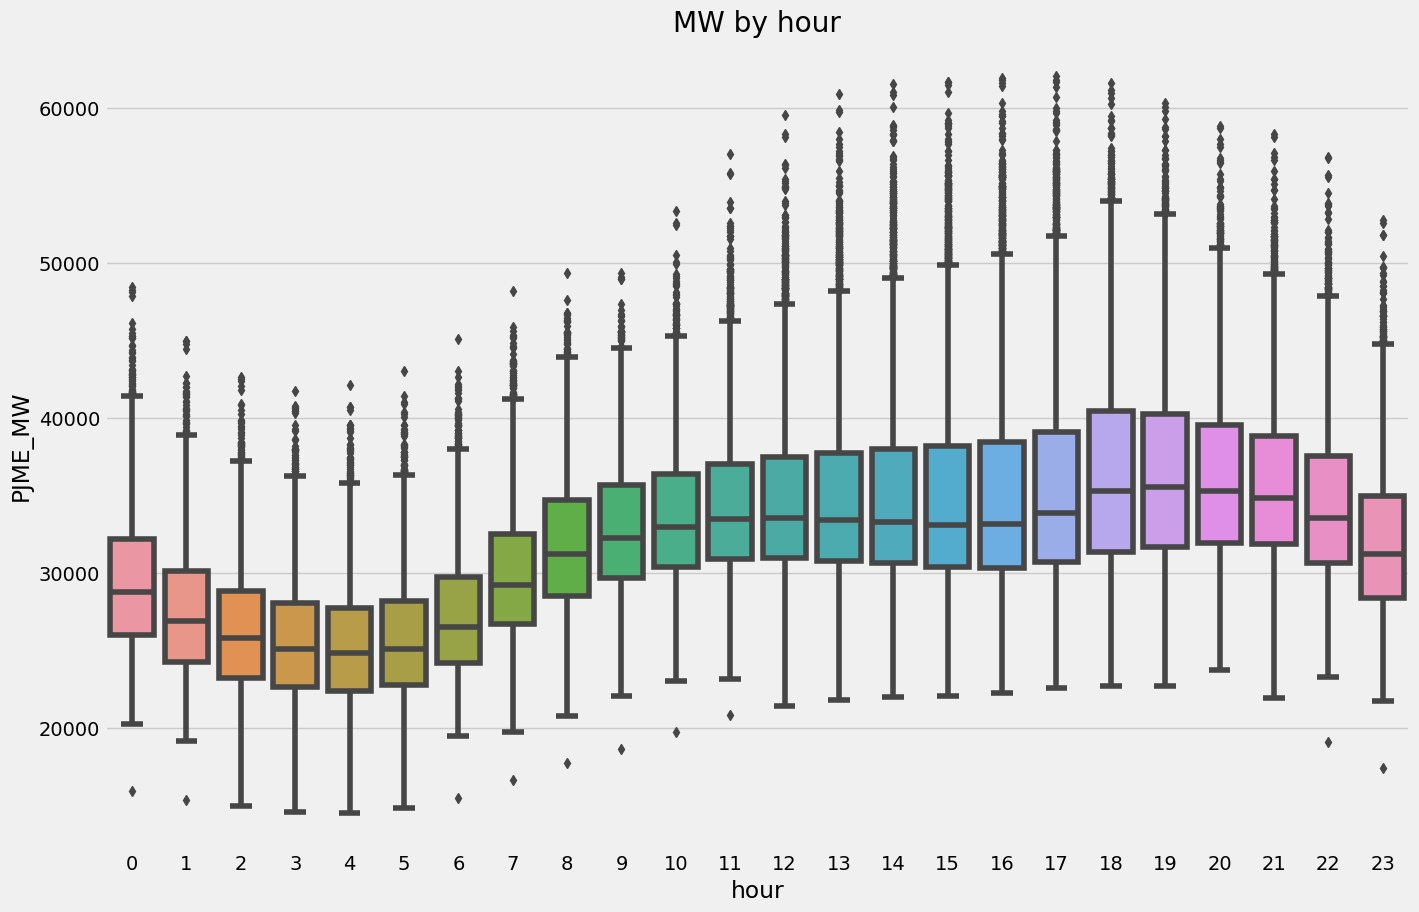

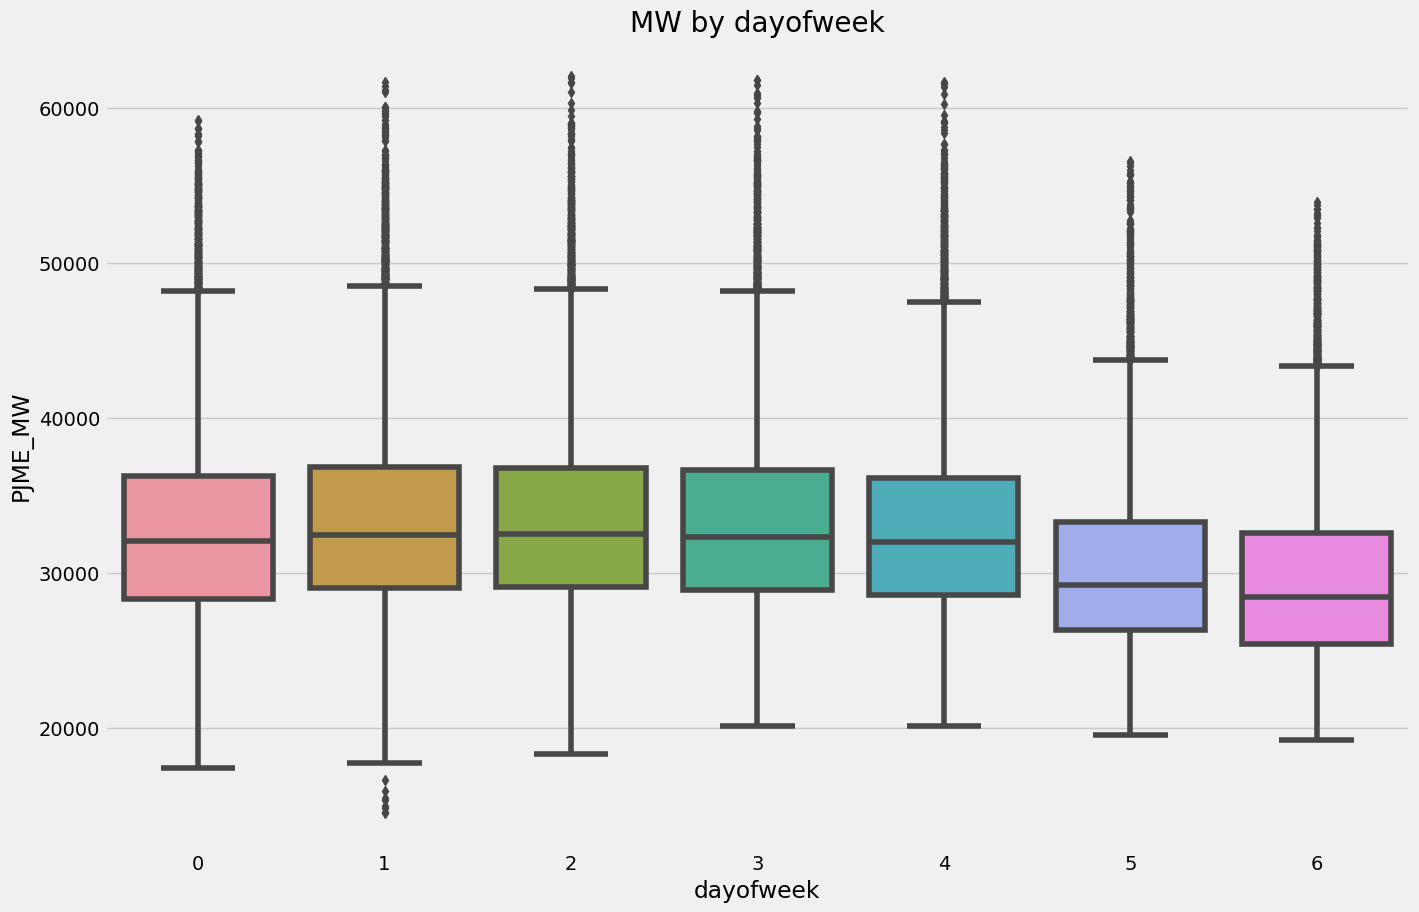

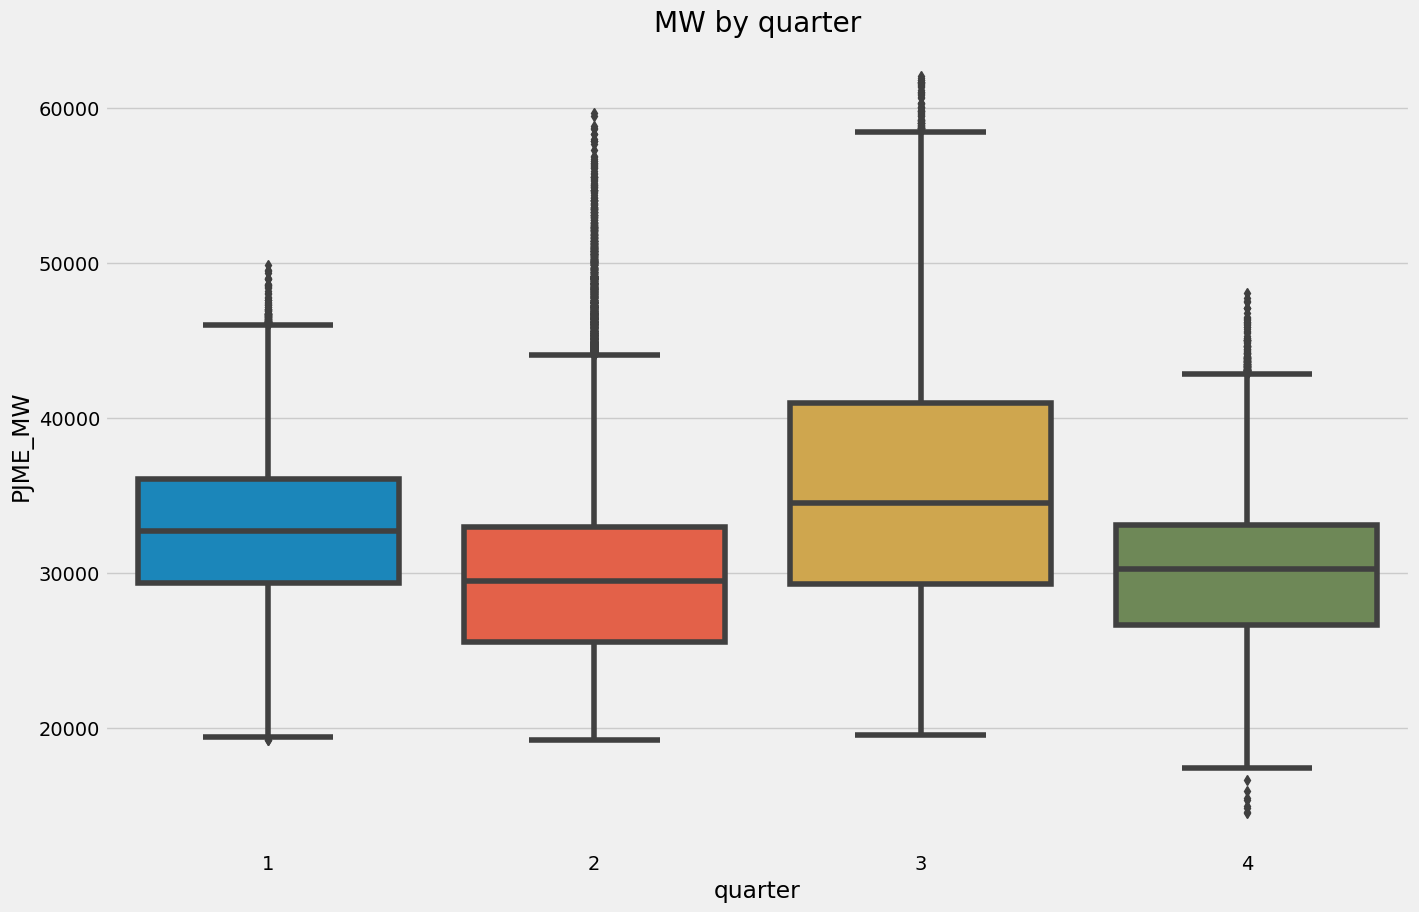

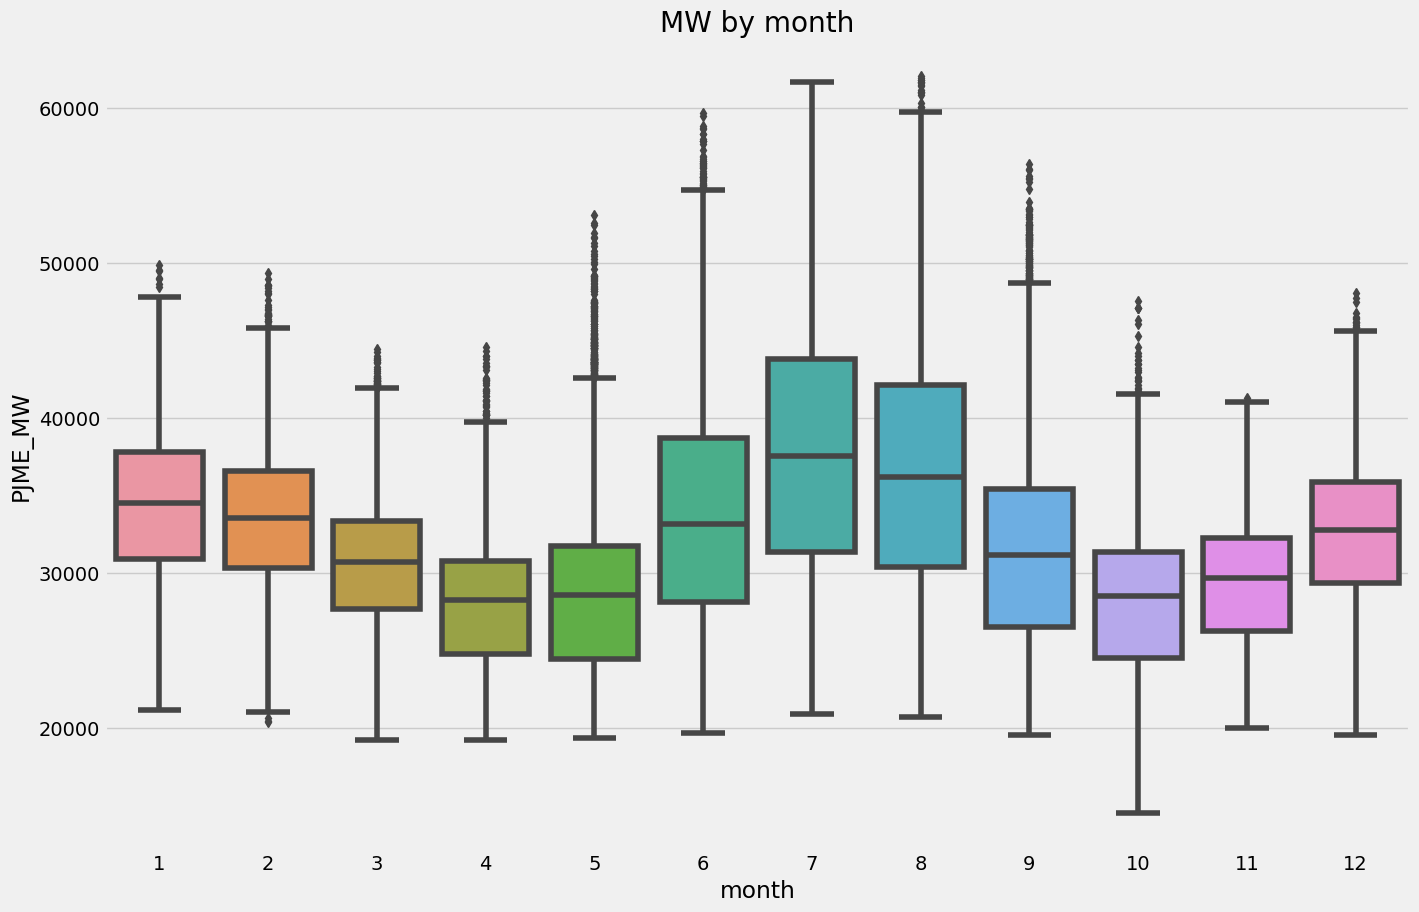

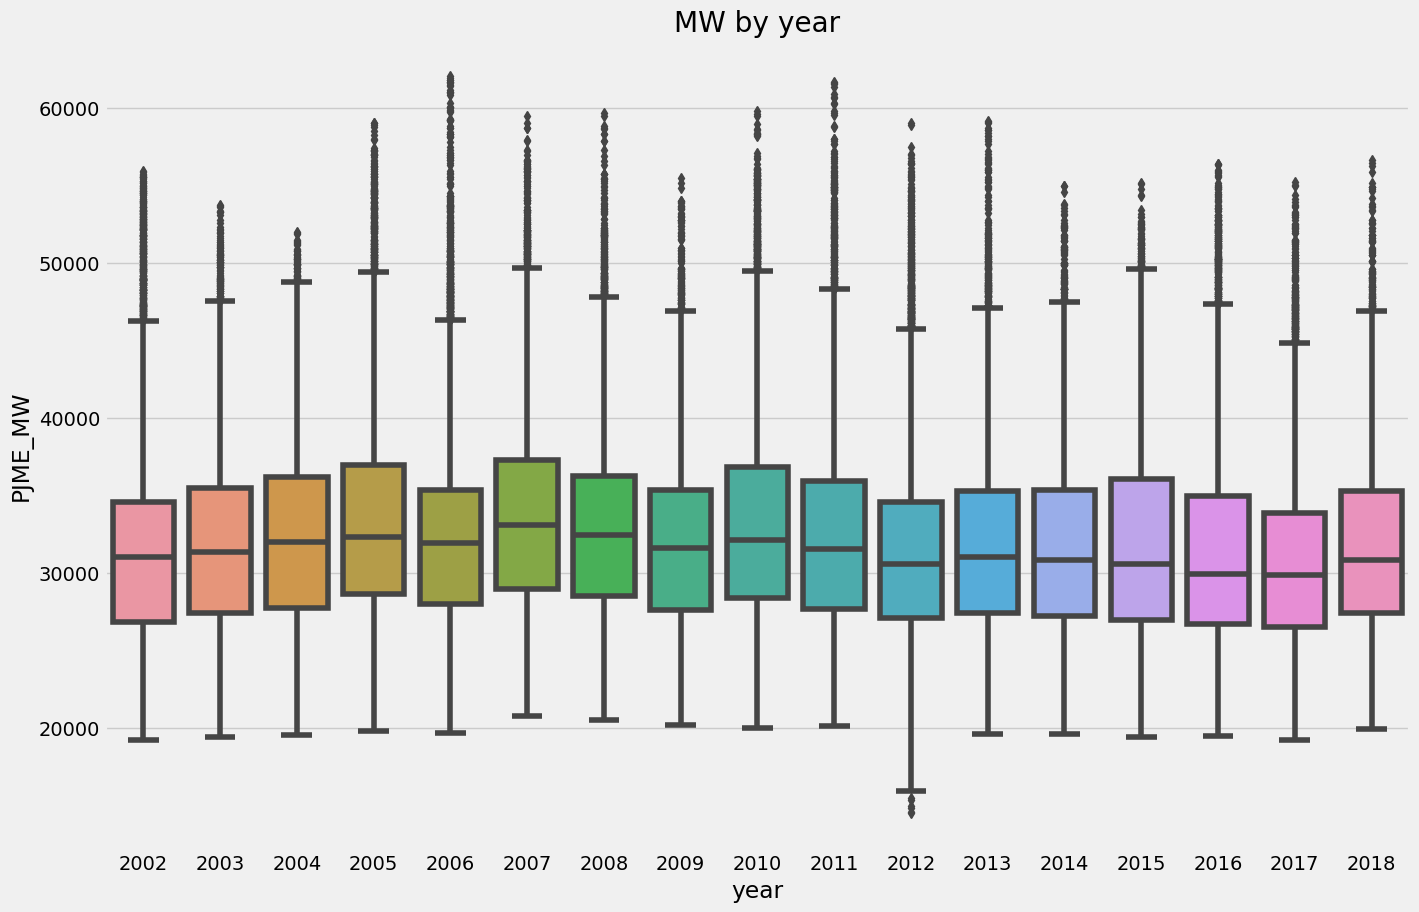

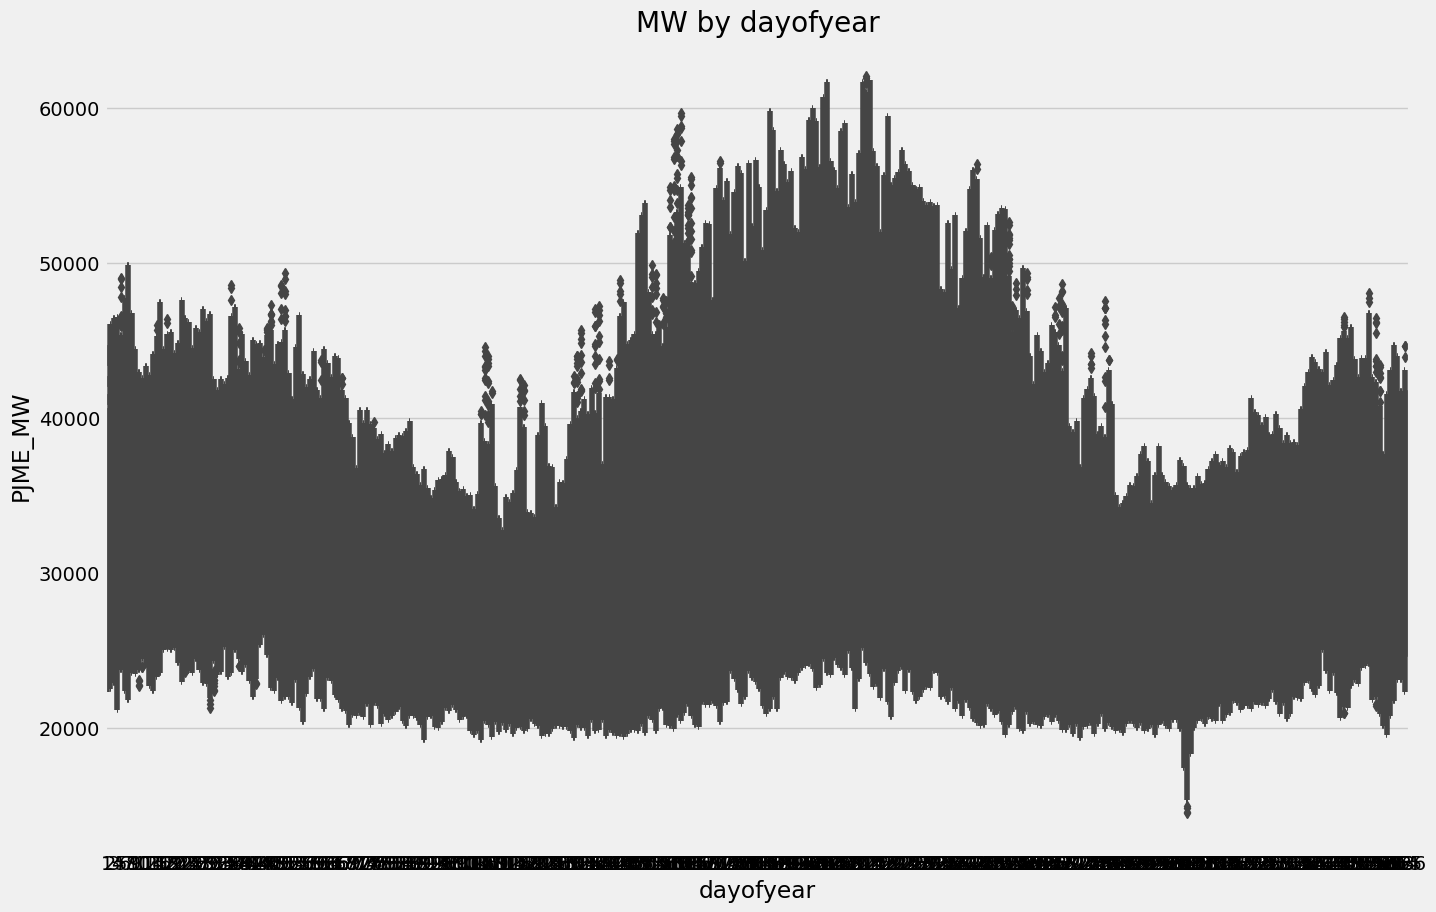

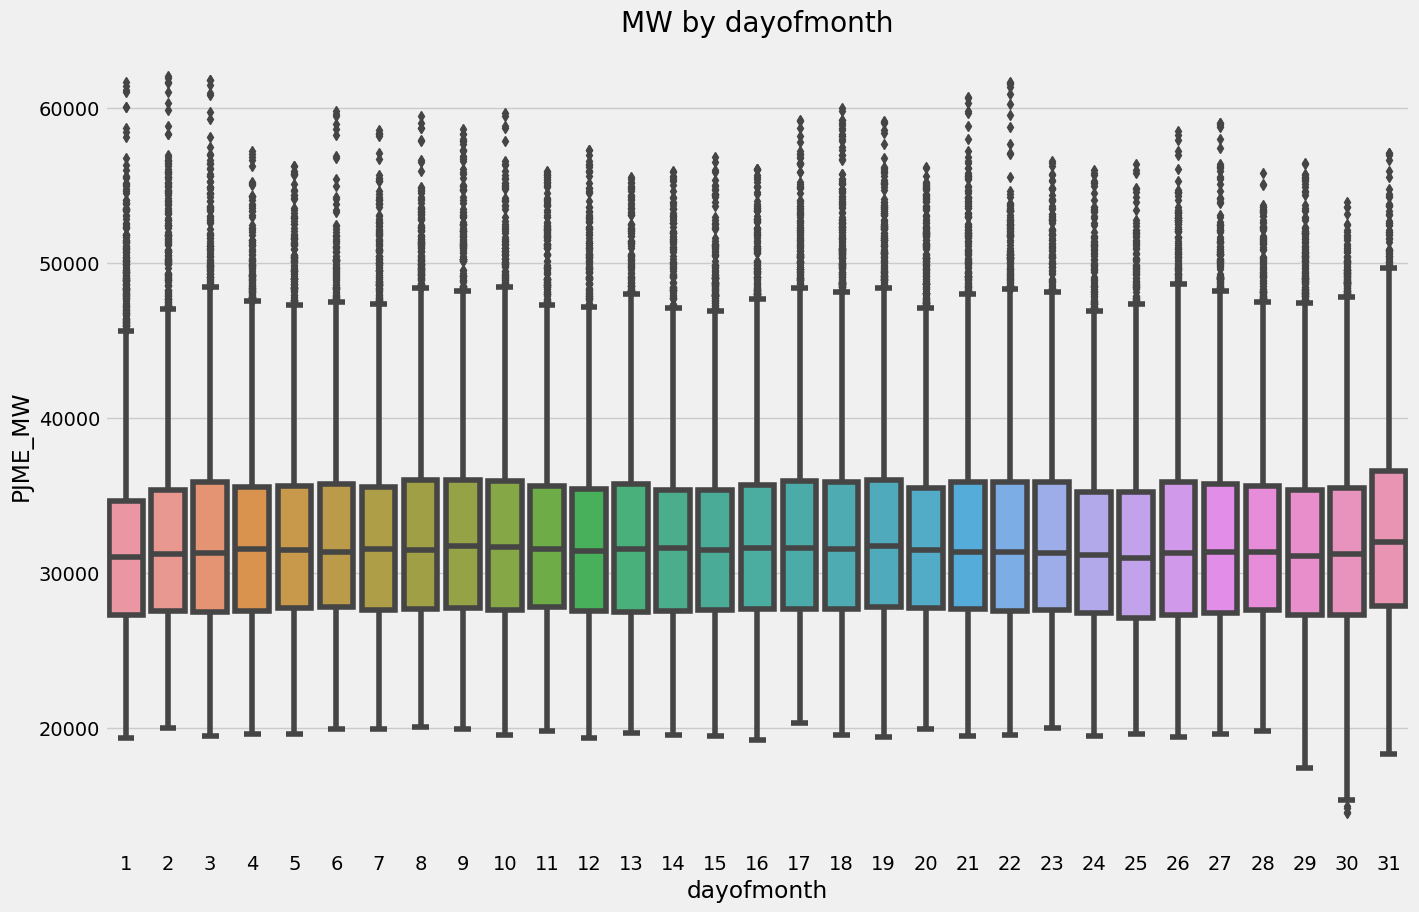

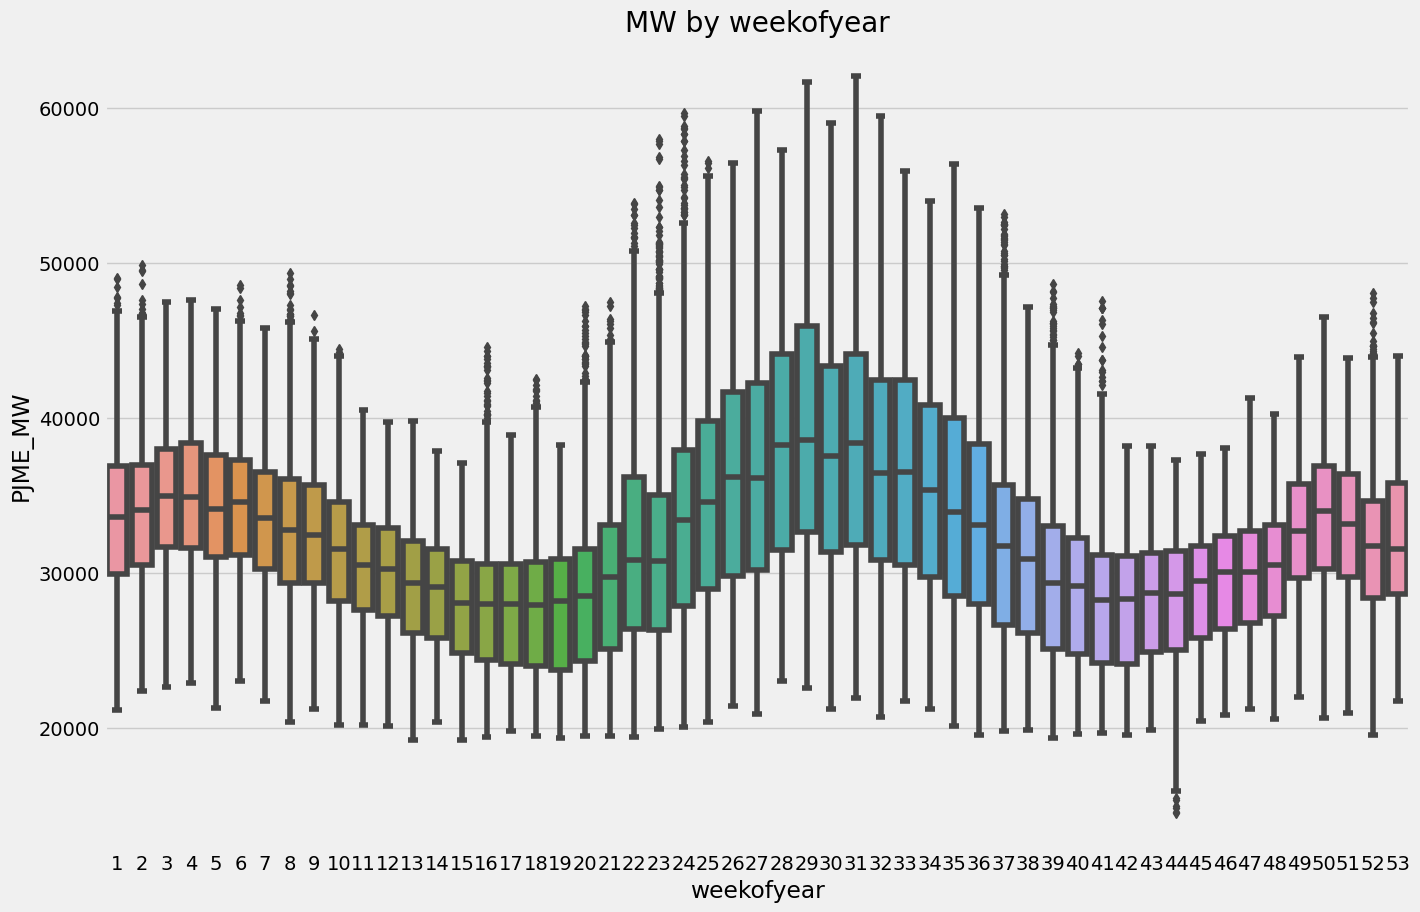

In [7]:
for col in df.columns:
    if col == 'PJME_MW':
        continue
    fig, ax = plt.subplots(figsize=(15,10))
    sns.boxplot(data=df, x=col, y='PJME_MW')
    ax.set_title(f'MW by {col}')
    plt.show()

# **Model**

In [8]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
reg = xgb.XGBRegressor(
    base_score = 0.5,
    booster = 'gbtree',
   n_estimators=1000,
   early_stopping_rounds=50,
   objective='reg:linear',
   max_depth=3,
   learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:38:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

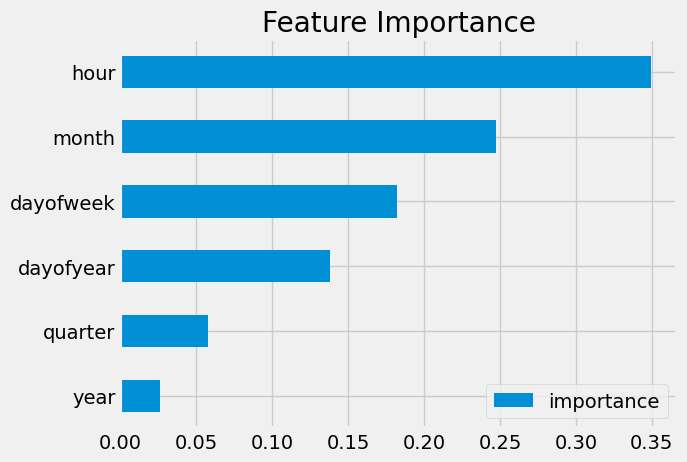

In [10]:
# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                  columns=['importance']
                 )
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# **Testing**

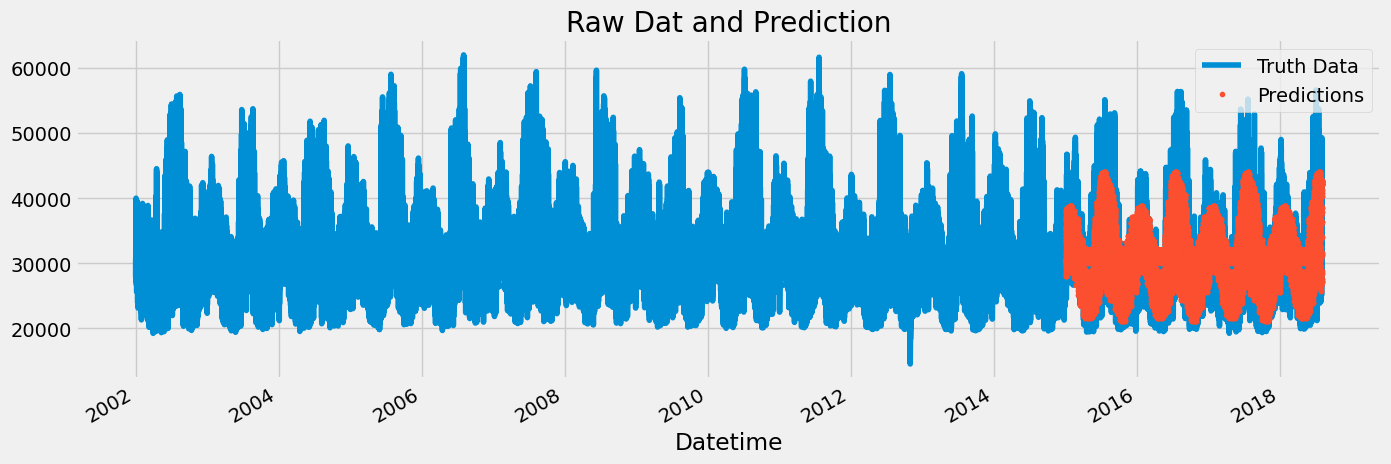

In [11]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [12]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [13]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64